<a href="https://colab.research.google.com/github/nidhin-koshy/ML_AI_IISc/blob/master/33_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

 Clustering is a non-supervised learning task, where the aim is to group the samples in to distinct clusters. 
 
 In this module we will look at two popular clustering techniques - 1) K-means algorithm, and 2) spectral clustering  methods.

## K-means algorithm

K-means algorithm partitions the input samples in to K clusters. It is a simple clustering technique which works well for convex and isotropic clusters. K-means does not work well for irregular shaped clusters. It is an iterative algorithm that tries to find the optimum cluster centroids such that the intra-cluster distances from the centroids (also known as inertia ) are minimized. With each iteration the inertia is reduced and hence the algorithm is bound to converge, at least to a local minima. The problem with convergence to a local minima can be addressed by running the algorithm multiple times with different initializations for the centroids and choosing the best run. We now provide a high-level description of the K-means algorithm.

     K-means(input_samples,num_clusters)
       centroids = initialize_centroids(num_clusters)
       while(centriods not converged)
         labels = assign_new_labels(input_samples, centroids)
         centroids = compute_new_centroids(input_samples,labels)
       end while

In [0]:
#import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Generate synthetic cluster data points

comb_mat =  [[ 1.  0.]
 [ 0. 10.]]


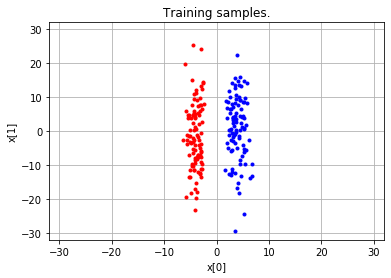

In [48]:
#generate data points for clustering
#generate isotropic Gaussian distributed clusters
num_x1_samples = 100 # number of samples from Class 1
num_x2_samples = 100 # number of samples from Class 2
theta_rot = (-np.pi)/4
sigma_1 = 1
sigma_2 = 10
rot_mat = np.eye(2) #np.array([[np.cos(theta_rot), -np.sin(theta_rot)],[np.sin(theta_rot), np.cos(theta_rot)]])
cov_sqrt = np.array([[sigma_1,0],[0,sigma_2]])
comb_mat = np.matmul(rot_mat,cov_sqrt).T
print("comb_mat = ",comb_mat)

mu_1 = np.array([[4,0]]).T # Mean of the points in Class 1
mu_2 = np.array([[-4,0]]).T # Mean of the points in Class 2

x1 = np.random.randn(num_x1_samples,2)  # Generate num_x1_samples points for Class 1, with mean of mu_1
y1 = np.ones((num_x1_samples,1)) # Assign a label of +1 to the samples from Class 1
x1=np.matmul(x1,comb_mat)+ mu_1.T

x2 = np.random.randn(num_x2_samples,2) # Generate num_x2_samples points for Class 2, with mean of mu_2
y2 = -1*np.ones((num_x2_samples,1)) # Assign a label of -1 to the samples from Class 2
x2=np.matmul(x2,comb_mat)+ mu_2.T 

x_train = np.concatenate((x1,x2),axis=0) # The training data will be a mix of the samples from Class 1 and Class 2. Here we are stacking the rows on top of each other
y_train = np.concatenate((y1,y2),axis=0) # Just as the sample points were concatenated, we need to concatenate the labels

#Shuffle training samples. The samples we obtain in practise might be in random order.
perm = np.random.permutation(y_train.size)

x_train = x_train[perm,:]
y_train = y_train[perm,:]



plt.plot(x1[:,0],x1[:,1],'.b')
plt.plot(x2[:,0],x2[:,1],'.r')
plt.grid()
plt.title("Training samples.")
plt.xlabel("x[0]")
plt.ylabel("x[1]")
axis_max = (max(np.absolute(plt.xlim()+plt.ylim())))
plt.xlim((-axis_max,axis_max))
plt.ylim((-axis_max,axis_max))
plt.show()


### Define required functions

In [0]:
def initialize_centroids(input_samples,num_clusters):
 random_indices = np.random.randint(0,input_samples.shape[0],num_clusters)
 centroids = input_samples[random_indices,:]
 return centroids

def assign_new_labels(input_samples,centroids):
  distance_centroids=np.zeros((input_samples.shape[0],centroids.shape[0])) #initialize all distances to zeros
  count = 0
  for centroid in centroids:
    diff = input_samples - centroid
    distance = np.linalg.norm(diff,axis=1)
    distance_centroids[:,count] = distance
    count+=1
  labels = np.argmin(distance_centroids,axis=1)
  return labels

def inertia(input_samples,centroids,labels):
  inertia=0
  centroid_count = 0
  for centroid in centroids:
    diff = input_samples[labels==centroid_count] - centroid
    inertia+=np.sum(np.linalg.norm(diff,axis=1))
  return inertia/labels.size #average inertia

def compute_new_centroids(input_samples,labels,num_clusters):
  centroids=np.zeros((num_clusters,input_samples.shape[1]))  
  for count in np.arange(num_clusters):
    new_centroid = np.mean(input_samples[labels==count],axis=0)
    centroids[count,:]= new_centroid
    #print("count_compute_new_centroids = ",count, ".centroids = ", centroids)
  return centroids
  

def K_means_algo(input_samples,num_clusters,convergence_criteria=0.001):
  #print("input_samples = ",input_samples.shape, ". num_clusters = ",num_clusters)
  centroids_evol=np.zeros((num_clusters,input_samples.shape[1],1)) #variable to track evolution of centroids
  temp = np.zeros((num_clusters,input_samples.shape[1],1)) # temporary variable to enable appending of centroids_evol
  centroids=initialize_centroids(input_samples,num_clusters) #initialize the centroids
  centroids_evol[:,:,0] = centroids
  #print("initial centroids =",centroids)
  labels=assign_new_labels(input_samples,centroids) # assign cluster label for each input sample
  inertia_current = inertia(input_samples,centroids,labels) # compute total inertia for the current centroids
  inertia_prev = inertia_current+convergence_criteria+1 # +1 is added so that we enter the while loop for the first time
  count = 0
  #print("initial labels = ", labels[:5])
  while(abs(inertia_prev-inertia_current) > convergence_criteria and (count < 10000)):
    count+=1
    centroids = compute_new_centroids(input_samples, labels,num_clusters)
    temp[:,:,0] = centroids
    centroids_evol=np.append(centroids_evol,temp,axis=2) #add the current centroids to centroids_evol
    #print("count = ",count,"centroids = ", centroids)
    labels = assign_new_labels(input_samples,centroids)
    inertia_prev = inertia_current
    inertia_current = inertia(input_samples,centroids,labels)
  return centroids,labels,centroids_evol

### Call main function

In [49]:
num_clusters = 2
centroids,labels,centroids_evol=K_means_algo(input_samples=x_train,num_clusters=num_clusters)
print("Centroids = ", centroids)

Centroids =  [[ 0.70658154  6.71616959]
 [-1.06223365 -8.79485112]]


### Plot results

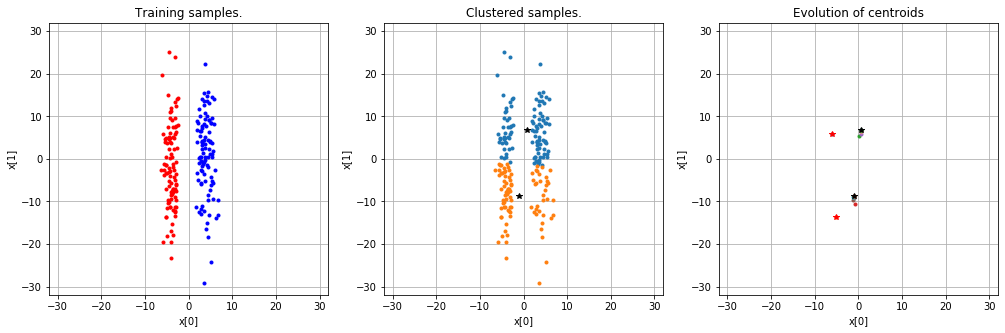

In [50]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(17,5))
axis1.plot(x1[:,0],x1[:,1],'.b')
axis1.plot(x2[:,0],x2[:,1],'.r')
axis1.grid()
axis1.set_title("Training samples.")
axis1.set_xlabel("x[0]")
axis1.set_ylabel("x[1]")
axis1.set_xlim((-axis_max,axis_max))
axis1.set_ylim((-axis_max,axis_max))

for count in np.arange(num_clusters):
  axis2.plot(x_train[labels==count][:,0],x_train[labels==count][:,1],'.')

axis2.plot(centroids[:,0],centroids[:,1],'k*')
axis2.grid()
axis2.set_title("Clustered samples.")
axis2.set_xlabel("x[0]")
axis2.set_ylabel("x[1]")
axis2.set_xlim((-axis_max,axis_max))
axis2.set_ylim((-axis_max,axis_max))

for evol_count in np.arange(centroids_evol.shape[2]):
  for count in np.arange(num_clusters):
    axis3.plot(centroids_evol[count,0,evol_count],centroids_evol[count,1,evol_count],'.')
axis3.plot(centroids_evol[:,0,0],centroids_evol[:,1,0],'r*')
axis3.plot(centroids_evol[:,0,-1],centroids_evol[:,1,-1],'k*')
axis3.grid()
axis3.set_title("Evolution of centroids")
axis3.set_xlabel("x[0]")
axis3.set_ylabel("x[1]")
axis3.set_xlim((-axis_max,axis_max))
axis3.set_ylim((-axis_max,axis_max))

plt.show()



### Exercises
* Try the k-means algorithm on  non-isotropic clusters
* Try varying the number of clusters in data and the num_clusters argument passed to the K-means function

## Spectral Clustering

Spectral clustering is a clustering thechnique that maps the input data points to a different space and does the clustering in that space. Spectral techniques are robust to non-isotropic data clusters. We will now describe the algorithm.

Let $x_1,x_2, \ldots, x_n$ be the $n$ data points that need to be clustered. Let $K$ denote the number of clusters to be computed. Let $S \in \mathcal{R}^{n\times n}$ be the similarity matrix with $S_{ij} = S_{ji} \ge 0$.



Let $d_{i} = \sum_{j=1}^n S_{ij}$ be the degree of node $i$. Let $D = diag(d_i, d_2,\dots,d_n)$ be the degree matrix.

Let $L = D-S$ denote the Laplacian matrix associated with $S$. This is also called the un-normalized Laplacian.

### Properties of the Laplacian matrix $L$
* For every $f \in \mathcal{R}^n$ we have
$$f^TLf = \frac{1}{2} \sum_{i,j}S_{ij}(f_i - f_j)^2 \ge 0.$$
* $L$ is symmetric and positive semi-definite
* The smallest eignvalue of $L$ is zero, and the corresponding eigenvector is the all one vector $\mathbf{1}.$
* $L$ has $n$ non-negative, real-valued eigenvalues = $0\le \lambda_1\le\lambda_2\ldots \le \lambda_n.$

  ### Spectral Clustering Algorithm with non-normalized Laplacian:
  * Input: Similarity matrix $S \in \mathcal{R}^{n\times n}$, number $k$ of clusters to construct
    * Compute the Laplacian $L$
    * Compute the first $k$ eigenvectors $u_i, u_2, \ldots, u_k$ of $L$
    * Let $U  = [u_1, u_2, \ldots, u_k] \in \mathcal{R}^{n \times k}.$
    * Let the rows of $U$ be the new data points, i.e., let $y_i$ denote the $i$th row of $U$.
    * Find k clusters $C_i, C_2, \ldots, C_k$ of the new data points $y_1, y_2, \dots, y_n$ using clustering methods like K-means.
  *Output: Clusters $A_1,A_2,\ldots,A_k$ with $A_i = \{j | y_j \in C_i\}$

### Implement Spectral Clustering

Let $S_{ij} = e^{-\frac{\Vert x_i -x_j\Vert^2}{2\sigma^2}}$. This is the popular euclidean distance based similarity matrix. Any symmetric matrix with non-negative entries can be used as a similarity matrix.

In [0]:
#Spectral Clustering
from scipy.spatial.distance import cdist
S_sigma_square = 1
dist = cdist(x_train,x_train,metric='euclidean')/(2*S_sigma_square)
S = np.exp(-dist)
D = np.diag(np.sum(S,axis=1,keepdims=False))
L = D-S
#print("Sum of S = ",np.sum(S,axis=1,keepdims=False)[:5])
#print("D =", D[:5,:5])
#print("S = ",S[:5,:5])
#print("L = ",L[:5,:5])
#print("sum L = ",np.sum(L,axis=1,keepdims=False)[:5] )
eigenvalues,eigenvectors = np.linalg.eig(L)
idx = np.argsort(eigenvalues)   #sort eigenvalues
eigenvalues = eigenvalues[idx]
#print("eigenvalues = ",eigenvalues[:10])
eigenvectors = eigenvectors[:,idx] #arrange eigenvectors in sorted order
U_k = eigenvectors[:,0:num_clusters]
#print("U_k = ", U_k[:10,:])
centroids_spectral,labels_spectral,centroids_evol_spectral=K_means_algo(input_samples=U_k,num_clusters=num_clusters)

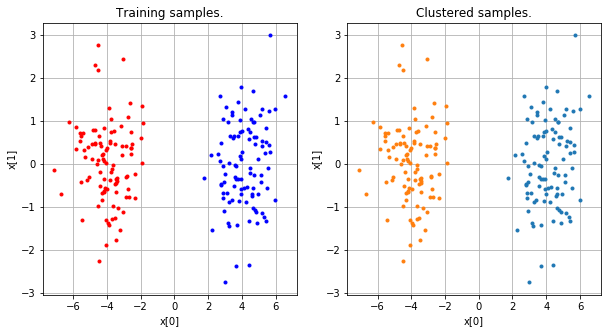

In [46]:
#Plot Results
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
axis1.plot(x1[:,0],x1[:,1],'.b')
axis1.plot(x2[:,0],x2[:,1],'.r')
axis1.grid()
axis1.set_title("Training samples.")
axis1.set_xlabel("x[0]")
axis1.set_ylabel("x[1]")

for count in np.arange(num_clusters):
  axis2.plot(x_train[labels_spectral==count][:,0],x_train[labels_spectral==count][:,1],'.')

#axis2.plot(centroids_spectral[:,0],centroids_spectral[:,1],'k*')
axis2.grid()
axis2.set_title("Clustered samples.")
axis2.set_xlabel("x[0]")
axis2.set_ylabel("x[1]")

plt.show()

  ### Spectral Clustering Algorithm with normalized Laplacian:
  * Input: Similarity matrix $S \in \mathcal{R}^{n\times n}$, number $k$ of clusters to construct
    * Compute the Laplacian $L_{norm} = I - D^{-1/2}S D^{-1/2}$
    * Compute the first $k$ eigenvectors $u_i, u_2, \ldots, u_k$ of $L_{norm}$
    * Let $U  = [u_1, u_2, \ldots, u_k] \in \mathcal{R}^{n \times k}.$
    * Let the rows of $U$ be the new data points, i.e., let $y_i$ denote the $i$th row of $U$
    * Normalize the rows of $U$ to unit norm vectors..
    * Find k clusters $C_i, C_2, \ldots, C_k$ of the new data points $y_1, y_2, \dots, y_n$ using clustering methods like K-means.
  *Output: Clusters $A_1,A_2,\ldots,A_k$ with $A_i = \{j | y_j \in C_i\}$

In [0]:
#Spectral Clustering with normlized Laplacian
from scipy.spatial.distance import cdist
S_sigma_square = 1
dist = cdist(x_train,x_train,metric='euclidean')/(2*S_sigma_square)
S = np.exp(-dist)
diag_vector = np.sum(S,axis=1,keepdims=False)
diag_vector_sqrt_inv = 1/np.sqrt(diag_vector)
D = np.diag(np.sum(S,axis=1,keepdims=False))
D_sqrt_inv = np.diag(diag_vector_sqrt_inv)
L = D-S
L_norm = np.matmul(D_sqrt_inv,L)
L_norm = np.matmul(L_norm,D_sqrt_inv)
#print("Sum of S = ",np.sum(S,axis=1,keepdims=False)[:5])
#print("D =", D[:5,:5])
#print("S = ",S[:5,:5])
#print("L_norm = ",L_norm[:5,:5])
#print("sum L = ",np.sum(L,axis=1,keepdims=False)[:5] )
eigenvalues_norm,eigenvectors_norm = np.linalg.eig(L_norm)
idx = np.argsort(eigenvalues_norm)   #sort eigenvalues
eigenvalues_norm = eigenvalues_norm[idx]
#print("eigenvalues_norm = ",eigenvalues_norm[:10])
eigenvectors_norm = eigenvectors_norm[:,idx] #arrange eigenvectors in sorted order
U_k_norm = eigenvectors_norm[:,0:num_clusters]
U_k_norm = U_k_norm/np.linalg.norm(U_k_norm,axis=1,keepdims=True)
#print("U_k_norm = ", U_k_norm[:10,:])
centroids_spectral_norm,labels_spectral_norm,centroids_evol_spectral_norm=K_means_algo(input_samples=U_k_norm,num_clusters=num_clusters)

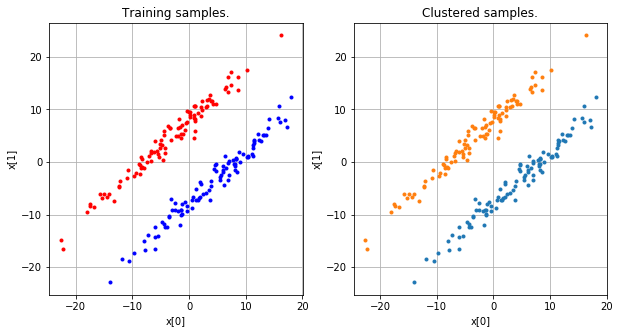

In [0]:
#Plot Results
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
axis1.plot(x1[:,0],x1[:,1],'.b')
axis1.plot(x2[:,0],x2[:,1],'.r')
axis1.grid()
axis1.set_title("Training samples.")
axis1.set_xlabel("x[0]")
axis1.set_ylabel("x[1]")

for count in np.arange(num_clusters):
  axis2.plot(x_train[labels_spectral_norm==count][:,0],x_train[labels_spectral_norm==count][:,1],'.')

#axis2.plot(centroids_spectral[:,0],centroids_spectral[:,1],'k*')
axis2.grid()
axis2.set_title("Clustered samples.")
axis2.set_xlabel("x[0]")
axis2.set_ylabel("x[1]")

plt.show()

## Exercises
* Try to implement K-means and Spectral Clustering using the in-built functions available with Scikit-Learn. The link to the scikit-learn documentation on clustering is given below. 

## Resources
* Scikit Learn documentation for clustering - https://scikit-learn.org/stable/modules/clustering.html
* Tutorial on spectral clustering - [here](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E23FB97AFEFB3E59F906B4CED88A98B2?doi=10.1.1.165.9323&rep=rep1&type=pdf)
